In [1]:
from potential_initialization import *
from trap_model import *
%load_ext autoreload
%autoreload 2

d:\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [22]:
# 缓存pseudo potential在一个字典中，若在调试时修改了trap_model的定义可以快速初始化
pbi= dict()

In [30]:
# 设置需要计算势场的区域
shuttle_range = [[-0.5, 0.5], [-0.1, 0.1], [0.05, 0.2]]
stepsize = 0.025

# rf电压和频率需要提前设置
V_rf = 170
omega_rf = 2 * np.pi * 30e6
# 初始化trap_model类型
junction = trap_model("junction", V_rf, omega_rf, shuttle_range, stepsize, pbi, regenerate=False)

  0%|          | 0/41 [00:00<?, ?it/s]

这tqdm有大病


100%|██████████| 41/41 [00:00<00:00, 126.55it/s]


d:\Anaconda\lib\site-packages\ndsplines\ndsplines.py:201: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(x)


0.05938201647873942

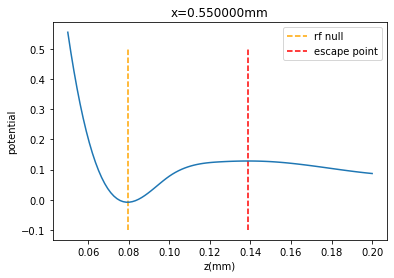

In [61]:
junction.depth_of_trap(0.55, True)

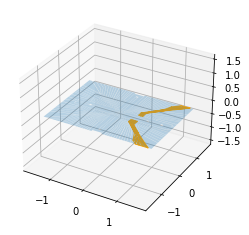

In [33]:
# 高亮编号为[2, 5, 7, 8, 10]的电极
junction.plot(part_id=[2, 5, 7, 8, 10])

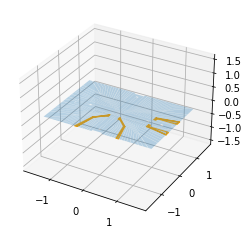

In [34]:
# 高亮名称为R-0和R-11的两对电极
junction.plot(electrodode=['D-0', 'R-11'])

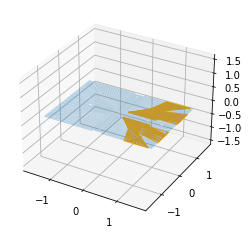

In [35]:
#高亮1、8两个区域的电极
junction.plot(sector=[1, 8])

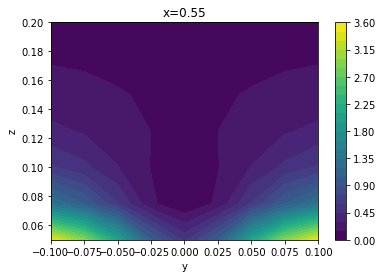

In [62]:
# 也可以在使用过程中重新设置rf参数
junction.reset_rf(V_rf=170, omega_rf=omega_rf)
# 计算在dc电压全部为0的时候，x=0.55mm的势场截面
junction.plot_slice(voltage=np.zeros(94), x=0.55)

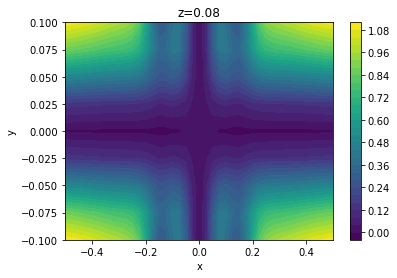

In [63]:
# 计算在第1、8区域的电极电压为1V，其余dc电极电压为0V时，z=0.55mm的势场截面
# indices = junction.get_indices(use_sectors=[1, 8])
voltage = np.zeros(94)
# voltage[indices] = 1
junction.plot_slice(voltage, z=0.08)

In [38]:
# 计算x=0.4和0.5时的rf零点(输运方向需要在x方向)
points = junction.rf_null_point([0.4, 0.5])
points

array([[ 4.00000000e-01, -1.13232953e-05,  8.01537922e-02],
       [ 5.00000000e-01, -1.59035097e-05,  7.96490634e-02]])

In [39]:
# 计算这两个点处的势能
junction.potential(voltage, points)

array([-0.01092519, -0.00905988], dtype=float64)

In [40]:
# 假设不发生主轴旋转，计算这x=0.4时rf零点的阱频
junction.freq(points[0], voltages=np.zeros(94))

array([0.03656681, 2.6338354 , 3.26971954])

In [41]:
# 假设发生主轴旋转，计算这x=0.4时rf零点的阱频和主轴方向
junction.freq(points[0], voltages=np.zeros(94), rotate=True)

(array([0.03149649, 3.26977232, 2.6338354 ]),
 array([[ 9.99983858e-01, -5.68129358e-03, -8.26585332e-05],
        [-8.34979499e-05, -1.47513934e-04, -9.99999986e-01],
        [-5.68128131e-03, -9.99983850e-01,  1.47985929e-04]]))

In [42]:
# 计算x=0.56时，用最近的两对电极，在电压绝对值不超过10V的时候，将离子以默认频率[0.5, 3, 3]MHz囚禁在rf零点所需要的电压
point, voltage = junction.coord_voltage(x=0.56, top_nearest=2, max_voltage=10, paired=True, message=True)

Ion location at [ 5.60000000e-01 -1.51543524e-05  7.94493862e-02]
R-4: -2.438384814654027 V


d:\Workplace\PythonScripts\surface trap electrostatic field\trap_model.py:195: RuntimeWarning: invalid value encountered in sqrt
  omega = (np.array([hessian[0, 0], hessian[1, 1], hessian[2, 2]]) / 1e6 * q / m) ** 0.5 / (2 * np.pi)


In [43]:
# 带入计算得出的电压和rf零点，计算实际振动频率和方向
junction.freq(point, voltage, True)
# 此处的计算结果和优化目标较为符合

(array([0.47741593, 3.34886271, 2.73389104]),
 array([[ 9.99996757e-01,  2.53941035e-03,  1.93303353e-04],
        [ 1.83895543e-04,  3.70443358e-03, -9.99993122e-01],
        [ 2.54010896e-03, -9.99989914e-01, -3.70395458e-03]]))

In [44]:
# 如果发生主轴旋转，假设我们想要x方向仍为主轴，yz方向旋转45度，则先定义旋转矩阵
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

# 绕x轴旋转pi/4
R = M([1, 0, 0], np.pi / 4)

# 若电极配对，则无法完成旋转，故此处paired=False，用最近的8个电极，将生成的旋转矩阵导入，进行优化

w = [0, 1, 1, 1, 1, 1, 1, 10, 10, 10] # 权重需要重新调整

point, voltage = junction.coord_voltage(x=0.56, top_nearest=8, max_voltage=10, w=w, rotation=R, paired=False, message=True)

Ion location at [ 5.60000000e-01 -1.51543524e-05  7.94493862e-02]


In [45]:
# 优化还存在问题，显然没有找到最优解

junction.freq(point, voltage, True)

d:\Workplace\PythonScripts\surface trap electrostatic field\trap_model.py:510: RuntimeWarning: invalid value encountered in sqrt
  freq = (q * eig * 1e-6 / m) ** 0.5 / (2 * np.pi )


(array([       nan, 3.32559676, 2.78597034]),
 array([[ 9.99996932e-01,  2.47691009e-03, -3.55499167e-05],
        [ 3.50312772e-05,  2.09432775e-04,  9.99999977e-01],
        [-2.47691748e-03,  9.99996911e-01, -2.09345363e-04]]))

100%|██████████| 50/50 [01:41<00:00,  2.04s/it]


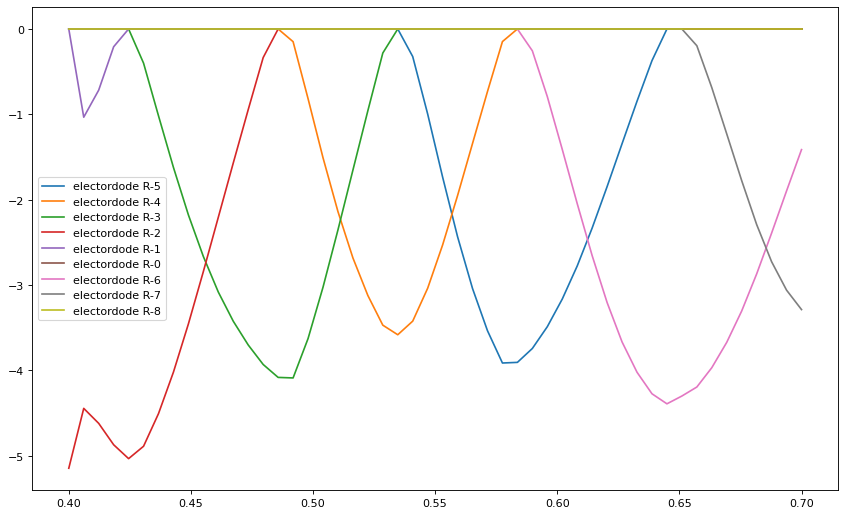

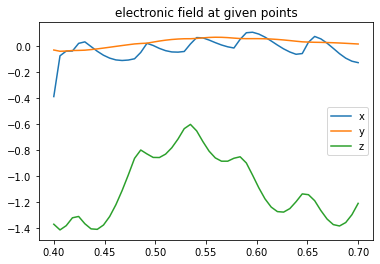

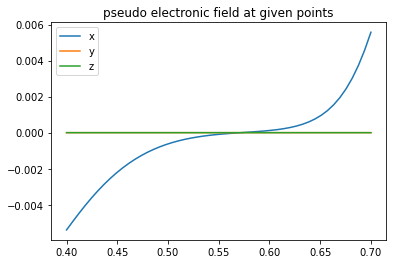

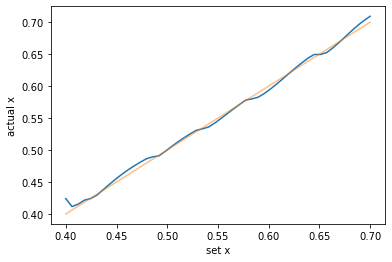

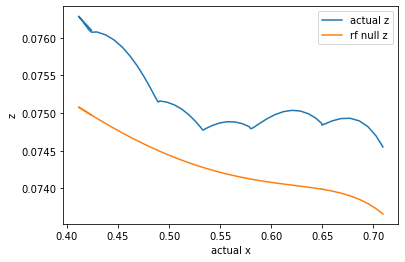

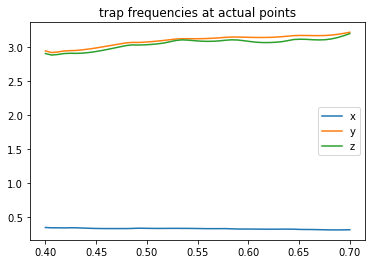

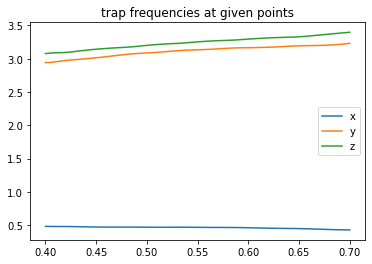

In [ ]:
junction.reset_rf(V_rf=180, omega_rf=omega_rf)
# 输运的方向沿x方向，由x=0.4到x=0.7
profile = np.linspace(0.4, 0.7, 50)
# alpha是电压随离子坐标的变化率上限，单位V/mm
# alpha * 输运速度 = 电压对时间的变化率上限
# w是权重向量
# omega表示三个方向的目标阱频，单位MHz
# max_voltage表示在优化过程中电压的上限
# confine_voltage表示非临近电极的电压值
# calc_position 表示是否返回离子在各个时间点的平衡位置


voltages, grads, frequencies, psEs, positions \
    = junction.optimized_voltage_profile(profile, top_nearest=5, alpha=200, w=[0, 1000, 0, 100, 100, 1, 1, 0.5, 0.5, 0],\
                                              omega=[0.5, 3, 3], confine_voltage=0, max_voltage=10, calc_position=True)